In the case when the ground state is a common state of both spin species, we resort to a spin-1 formulation, the following code implements the mean field of this description 

In [48]:
using DifferentialEquations, PyPlot, Statistics, LaTeXStrings, PyCall, LinearAlgebra

In [49]:
ENV["PYTHON"] = "C:\\Users\\admin\\Anaconda3\\envs\\data_vis\\python.exe"

LogNorm = pyimport("matplotlib.colors").LogNorm
cmap = pyimport("cmap")

lajolla = cmap.Colormap("crameri:lajolla").to_mpl();
balance = cmap.Colormap("cmocean:balance").to_mpl();
oslo = cmap.Colormap("crameri:oslo").to_mpl();
lipari = cmap.Colormap("crameri:lipari").to_mpl();
eclipse = cmap.Colormap("cmasher:eclipse").to_mpl();

# Configure LaTeX rendering and fonts
PyPlot.matplotlib[:rc]("text", usetex=true)
PyPlot.matplotlib[:rc]("font", family="serif", serif=["mathpazo"], size=18)  # Base font size
PyPlot.matplotlib[:rc]("axes", titlesize=22)             # Axis title
PyPlot.matplotlib[:rc]("axes", labelsize=20)             # Axis labels
PyPlot.matplotlib[:rc]("xtick", labelsize=18)            # X-ticks
PyPlot.matplotlib[:rc]("ytick", labelsize=18)            # Y-ticks
PyPlot.matplotlib[:rc]("legend", fontsize=18)            # Legend
PyPlot.matplotlib[:rc]("figure", titlesize=24)           # Figure title
PyPlot.svg(true)
# LaTeX preamble packages
PyPlot.matplotlib[:rc]("text.latex", preamble="\\usepackage{amsmath}\\usepackage{amsfonts}\\usepackage{amssymb}\\usepackage{lmodern}")

In [53]:
# Define the system of ODEs
function coupled_eqs!(du, u, p, t)
    Δ1, Δ2, g, φ, Δ, κ, η = p
    λ1, λ2, λ3, λ4, λ5, λ6, λ7, λ8, α_re, α_im = u

    # reconstruct complex field
    α    = α_re + im*α_im
    αc   = conj(α)
    expp = cis(φ)               # e^{iφ}
    expm = conj(expp)           # e^{-iφ}

    # compute λ-derivatives as complex then take real parts
    dλ1 = -Δ1*λ2 + im*g*(λ3*(α-αc) + expm*αc/2*(-im*λ5+λ4) + expp*α/2*(-im*λ5-λ4))
    dλ2 =  Δ1*λ1 + im*g*(im*λ3*(α+αc) + expm*αc/2*(im*λ4+λ5) + expp*α/2*(im*λ4-λ5))
    dλ3 =  im*g*(-im*λ2*(α+αc) + λ1*(αc-α) + expm*αc/2*(im*λ7-λ6) + expp*α/2*(im*λ7-λ6))
    dλ4 = (Δ1-Δ2/2)*λ5 + im*g*(αc/2*(im*λ7+λ6) + α/2*(im*λ7-λ6) + expm*αc/2*(-im*λ2-λ1) + expp*α/2*(-im*λ2+λ1))
    dλ5 = -(Δ1-Δ2/2)*λ4 + im*g*(αc/2*(-im*λ6+λ7) + α/2*(-im*λ6-λ7) + expm*αc/2*(im*λ1-λ2) + expp*α/2*(-im*λ1+λ2))
    dλ6 = -Δ2/2*λ7 + im*g*(αc/2*(im*λ5-λ4) + α/2*(im*λ5+λ4) + 1/2*(expp*α - expm*αc)*(√3*λ8 - λ3))
    dλ7 =  Δ2/2*λ6 + im*g*(αc/2*(-im*λ4-λ5) + α/2*(-im*λ4+λ5) + 1/2*(expp*α + expm*αc)*(√3*λ8 - λ3))
    dλ8 = -im*√3/2*g*(αc*expm*(im*λ7-λ6) + α*expp*(im*λ7+λ6))

    du[1] = real(dλ1)
    du[2] = real(dλ2)
    du[3] = real(dλ3)
    du[4] = real(dλ4)
    du[5] = real(dλ5)
    du[6] = real(dλ6)
    du[7] = real(dλ7)
    du[8] = real(dλ8)

    # α-equation (split into real and imaginary parts)
    dα = (Δ*im - κ/2)*α - im*g*((λ1 - im*λ2) + expm*(λ6 - im*λ7)) - η
    du[9]  = real(dα)
    du[10] = imag(dα)
end


coupled_eqs! (generic function with 1 method)

In [267]:
# Fixed parameters
Δ1, Δ2 = 0, 0
g, κ = 0.1, 1.0
Δ = 0.0
ϕ = 0
η = 1.0*g
# Time steps
tend = 10000.0;
t_list = range(0.0, tend, length=1001);

# Initial conditions
u0 = zeros(10); 
u0[3] = -1/2;
u0[8] = 1/(2*sqrt(3));


In [268]:
params = (Δ1, Δ2, g, ϕ, Δ, κ, η)
prob = ODEProblem(coupled_eqs!, u0, (0.0, tend), params)
sol = solve(prob, Tsit5(), saveat=t_list, reltol=1e-6, abstol=1e-9);

In [269]:
# Obtain populations of each level in the spin-1 system
N0 =  1/3 .- sol[3,:] + 1/sqrt(3) .* sol[8,:];
N1 = 1/3 .+ sol[3,:] + 1/sqrt(3) .* sol[8,:];
N2 = 1/3 .- 2/sqrt(3) .* sol[8,:];
Nt = N0 .+ N1 .+ N2;

lambda_t = sol[1,:].^2 + sol[2,:].^2 .+ sol[3,:].^2 .+ sol[4,:].^2 .+ sol[5,:].^2 .+ sol[6,:].^2 .+ sol[7,:].^2 .+ sol[8,:].^2;

In [275]:
minimum(lambda_t)

0.29430764709334856

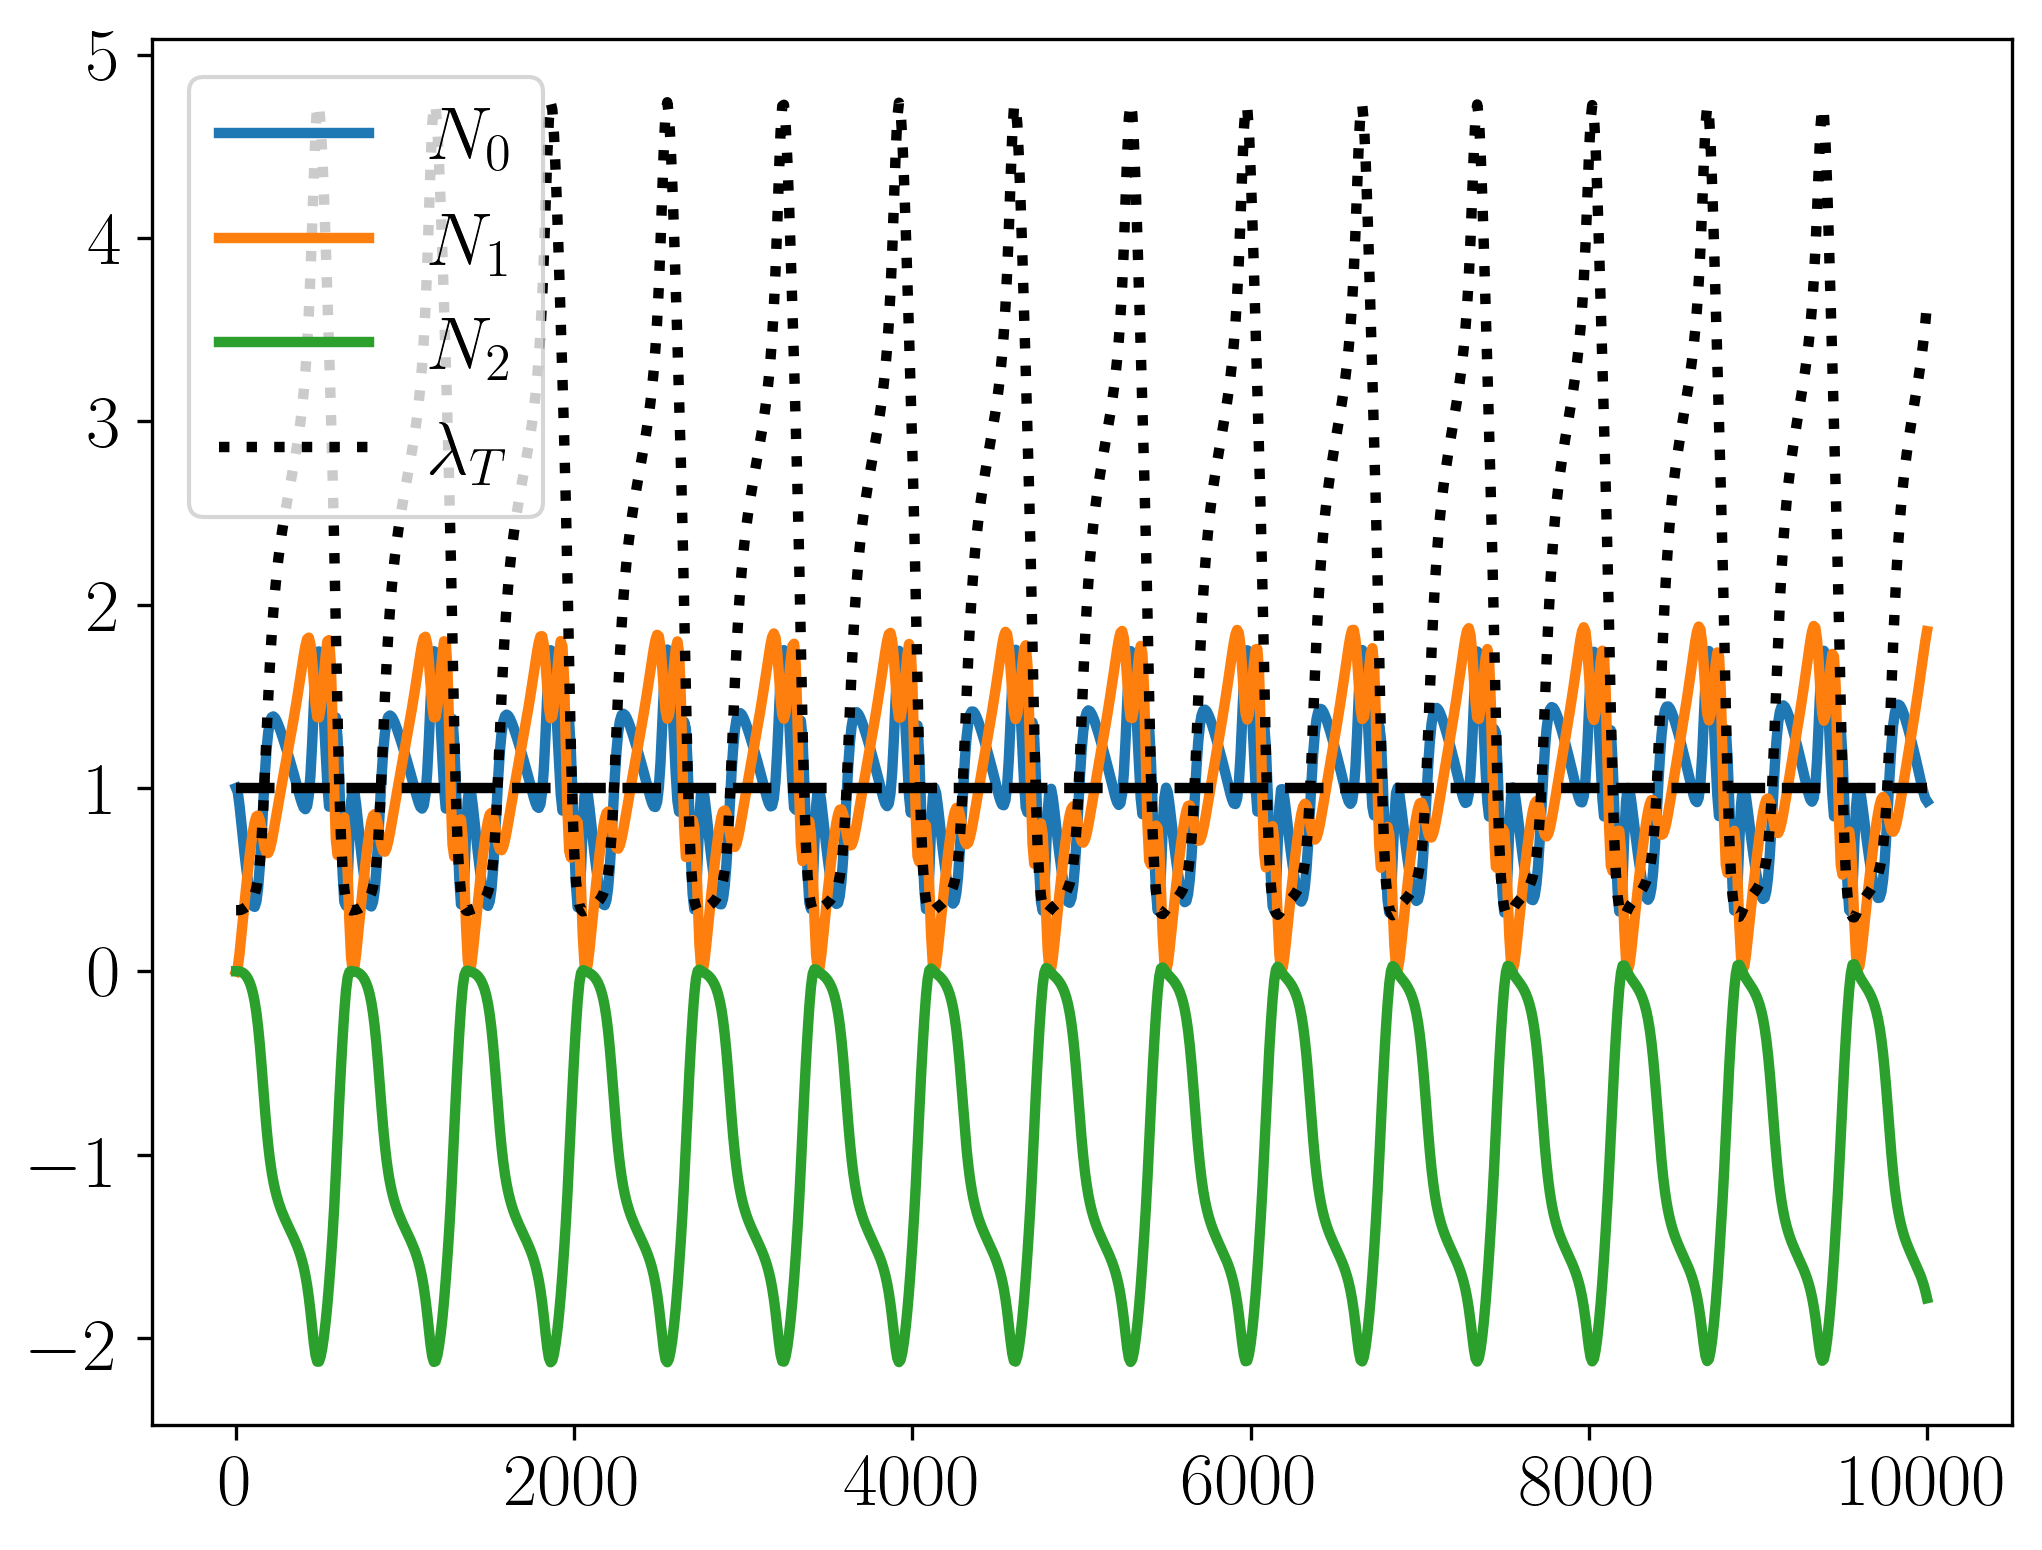

In [ ]:
fig, ax= subplots(figsize=(8, 6), dpi=300)
ax.plot(sol.t, N0, lw=2.5, label=L"N_0")
ax.plot(sol.t, N1, lw=2.5, label=L"N_1")
ax.plot(sol.t, N2, lw=2.5, label=L"N_2")
ax.plot(sol.t, Nt, lw=2.5, linestyle="--", color="blacK")
ax.plot(sol.t, lambda_t, lw=2.5, linestyle=":", color="black", label=L"$\lambda_T$")
ax.legend()
display(fig)

Map out mean field phase diagram 

In [134]:
# Parameter setup
η_vals = range(0.1*g, 1.5*g, length=101)
φ_vals = range(-π, π, length=101)


# Preallocate variance and mean arrays
var_N0 = zeros(length(φ_vals), length(η_vals))
var_N1 = zeros(length(φ_vals), length(η_vals))
var_N2 = zeros(length(φ_vals), length(η_vals))

mean_N0 = zeros(length(φ_vals), length(η_vals))
mean_N1 = zeros(length(φ_vals), length(η_vals))
mean_N2 = zeros(length(φ_vals), length(η_vals))


# Steady-state window: last 40% of the time series
total_pts = length(t_list)
ss_start = round(Int, 0.6 * total_pts):total_pts

# Loop over φ and η
for (i, φ_val) in enumerate(φ_vals)
    for (j, η_val) in enumerate(η_vals)
        # Update parameters and initial condition
        params = (Δ1, Δ2, g, φ_val, Δ, κ, η_val)
        prob = ODEProblem(coupled_eqs!, u0, (0.0, tend), params)

        # Solve
        sol = solve(prob, Tsit5(), saveat=t_list, reltol=1e-6, abstol=1e-9)

        # Extract steady-state data
        N0_ss =  1/3 .- sol[3,ss_start] + 1/sqrt(3) .* sol[8,ss_start];
        N1_ss = 1/3 .+ sol[3,ss_start] + 1/sqrt(3) .* sol[8,ss_start];
        N2_ss = 1/3 .- 2/sqrt(3) .* sol[8,:];


        # Compute variances and mean
        var_N0[i, j] = var(N0_ss)
        var_N1[i, j] = var(N1_ss)
        var_N2[i, j] = var(N2_ss)

        # Compute means
        mean_N0[i,j] = mean(N0_ss)
        mean_N1[i,j] = mean(N1_ss)
        mean_N2[i,j] = mean(N2_ss)
    end
end

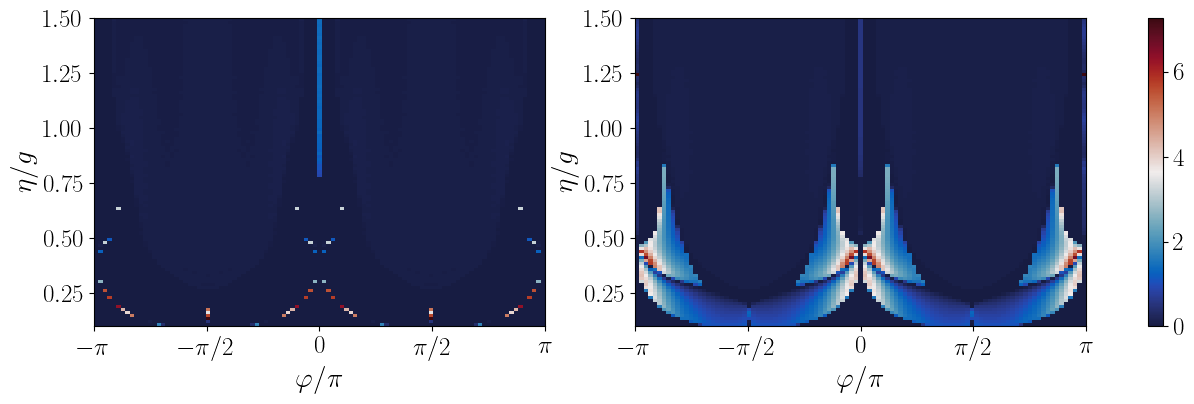

In [220]:
"""
Plot the variance phase diagram for a given N_i.

"""
x = φ_vals./π
y = η_vals./g


xtick_locs = [-1.0, -0.5, 0.0, 0.5, 1.0]  # x = φ/π
xtick_labels = [L"-\pi", L"-\pi/2", L"0", L"\pi/2", L"\pi"]


fig, axs = subplots(1, 2, figsize=(16, 4))


im1 = axs[1].imshow((var_N1)',
                     extent=(minimum(x), maximum(x), minimum(y), maximum(y)),
                     origin="lower",
                     aspect="auto", cmap=balance)     # Color limits
axs[1].set_ylabel(L"\eta/g")
axs[1].set_xlabel(L"\varphi/\pi")
axs[1].set_xticks(xtick_locs)
axs[1].set_xticklabels(xtick_labels)


im1 = axs[2].imshow((var_N2)',
                     extent=(minimum(x), maximum(x), minimum(y), maximum(y)),
                     origin="lower",
                     aspect="auto", cmap=balance)     # Color limits
axs[2].set_ylabel(L"\eta/g")
axs[2].set_xlabel(L"\varphi/\pi")
axs[2].set_xticks(xtick_locs)
axs[2].set_xticklabels(xtick_labels)
colorbar(im1, ax=axs)
display(fig)